In [ ]:
# ## Run 1. 

# import os
# from google import genai
# from google.oauth2 import service_account  # 인증 객체 생성을 위해 필요
# from google.genai.types import GenerateContentConfig

# # 1. JSON 키 파일 경로를 환경 변수에서 가져오기 (보안 강화)
# # 환경 변수 설정 방법:
# # export GOOGLE_APPLICATION_CREDENTIALS="/path/to/your/key.json"
# # export GOOGLE_CLOUD_PROJECT="your-project-id"
# KEY_PATH ="/home/syaro/stan_GCP_API.json"
# PROJECT_ID = "composed-hash-485105-k5"
# LOCATION = "us-central1"

# # 2. 인증 객체 생성 시 SCOPES 명시 (필수)
# # Vertex AI에 접근하기 위한 클라우드 플랫폼 스코프를 추가합니다.
# scopes = ['https://www.googleapis.com/auth/cloud-platform']
# credentials = service_account.Credentials.from_service_account_file(
#     KEY_PATH, 
#     scopes=scopes
# )

# # 3. Client 설정 시 credentials 전달
# client = genai.Client(
#     vertexai=True, 
#     project=PROJECT_ID, 
#     location=LOCATION,
#     credentials=credentials  # <--- 문자열이 아닌 객체를 전달!
# )

# # ============================================
# # 모델 설정
# # ============================================
# MODEL_ID = "gemini-2.5-flash"



/home/syaro/miniconda3/envs/minigrid/lib/python3.9/site-packages/google/auth/__init__.py:54: FutureWarning: 
    You are using a Python version 3.9 past its end of life. Google will update
    google-auth with critical bug fixes on a best-effort basis, but not
    with any other fixes or features. Please upgrade your Python version,
    and then update google-auth.
    
  warnings.warn(eol_message.format("3.9"), FutureWarning)
/home/syaro/miniconda3/envs/minigrid/lib/python3.9/site-packages/google/oauth2/__init__.py:40: FutureWarning: 
    You are using a Python version 3.9 past its end of life. Google will update
    google-auth with critical bug fixes on a best-effort basis, but not
    with any other fixes or features. Please upgrade your Python version,
    and then update google-auth.
    
  warnings.warn(eol_message.format("3.9"), FutureWarning)


In [3]:
## Run 2. 

## Utility Functions
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

# 일본어/한국어/중국어 폰트 설정
def setup_cjk_font():
    """CJK(중국어, 일본어, 한국어) 문자를 지원하는 폰트 찾기 및 설정"""
    # Linux에서 일반적으로 사용 가능한 CJK 폰트 목록
    cjk_fonts = [
        'Noto Sans CJK JP',  # Google Noto Sans (일본어)
        'Noto Sans CJK KR',  # Google Noto Sans (한국어)
        'Noto Sans CJK SC',  # Google Noto Sans (중국어 간체)
        'Noto Sans CJK TC',  # Google Noto Sans (중국어 번체)
        'Noto Sans JP',
        'Noto Sans KR',
        'Noto Sans SC',
        'Noto Sans TC',
        'DejaVu Sans',  # 기본 폰트 (CJK 미지원)
    ]
    
    # 시스템에 설치된 폰트 목록 가져오기
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    
    # 사용 가능한 CJK 폰트 찾기
    for font_name in cjk_fonts:
        if font_name in available_fonts:
            plt.rcParams['font.family'] = font_name
            print(f"폰트 설정: {font_name}")
            return font_name
    
    # 폰트를 찾지 못한 경우 경고
    print("경고: CJK 폰트를 찾을 수 없습니다. 일본어/한국어/중국어가 제대로 표시되지 않을 수 있습니다.")
    print("설치 방법: sudo apt-get install fonts-noto-cjk")
    return None

# 폰트 설정
setup_cjk_font()

폰트 설정: Noto Sans CJK JP


'Noto Sans CJK JP'

Output text: 日本で一番高い山は**富士山**です。

標高は**3,776メートル**で、静岡県と山梨県にまたがっています。


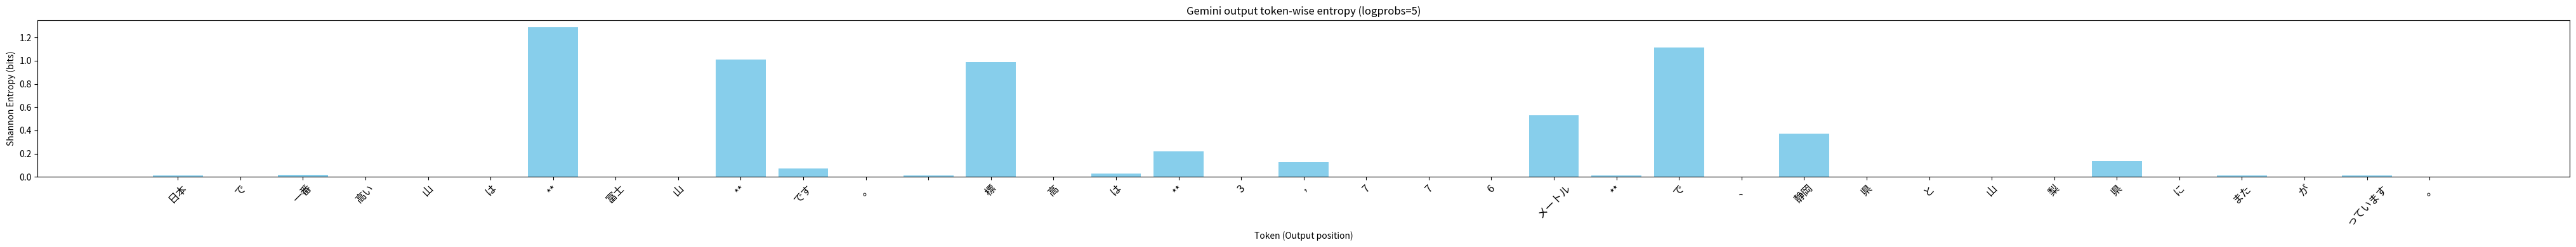

In [4]:


# Gemini-2.5-flash 모델 호출: logprobs=5로 각 위치의 토큰에 대해 상위 5개 logprob 정보를 요청
response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents='日本で一番高い山は？',
    config=genai.types.GenerateContentConfig(
        response_logprobs=True,
        logprobs=5
    )
)

# 출력 문장 추출
output_text = response.candidates[0].content.parts[0].text
print("Output text:", output_text)

# 각 토큰 위치별 토큰 및 top-5 logprob로 shannon entropy 계산
logprobs_result = response.candidates[0].logprobs_result
token_entropies = []
tokens = []

# logprobs_result 구조에 맞게 수정
for i, chosen in enumerate(logprobs_result.chosen_candidates):
    tokens.append(chosen.token)
    
    # top_candidates에서 해당 위치의 상위 후보들 가져오기
    if i < len(logprobs_result.top_candidates):
        top_candidates = logprobs_result.top_candidates[i]
        # top_candidates.candidates에서 확률 추출
        probs = []
        for cand in top_candidates.candidates:
            probs.append(np.exp(cand.log_probability))  # log_probability → 확률
        
        probs_sum = np.sum(probs)
        # (혹시 확률합이 1이 아니면 정규화)
        if probs_sum > 0:
            probs = [p / probs_sum for p in probs]
        else:
            # fallback: 확률이 모두 비정상적으로 0이면 균등분포 가정
            probs = [1/len(top_candidates.candidates)] * len(top_candidates.candidates)
        
        # shannon entropy 계산
        entropy = -np.sum([p*np.log2(p) if p > 0 else 0 for p in probs])
        token_entropies.append(entropy)
    else:
        # top_candidates가 없는 경우 (선택된 토큰만 사용)
        token_entropies.append(0.0)

# 결과 시각화
plt.figure(figsize=(max(6, len(tokens) * 1.1), 4))
plt.bar(range(len(tokens)), token_entropies, color='skyblue')
plt.xticks(range(len(tokens)), tokens, rotation=45, fontsize=12)
plt.xlabel('Token (Output position)')
plt.ylabel('Shannon Entropy (bits)')
plt.title('Gemini output token-wise entropy (logprobs=5)')
plt.tight_layout()
plt.show()


이미지 로드 완료: ./minigrid_debug.png (448x448)

=== 모델 출력 ===
east east east east


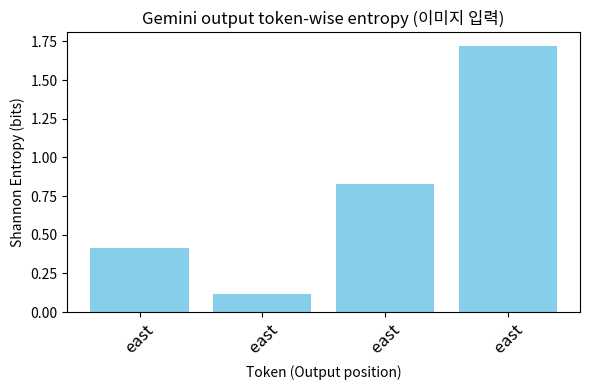


평균 토큰 엔트로피: 0.771 bits


In [11]:
## Experiment Related Variables 
# Image Directory
image_path = "./minigrid_debug.png"  # 여기에 이미지 경로 입력

# 프롬프트 설정: system prompt와 user prompt 분리
system_prompt = """
## ACTION SPACE (FUNDAMENTALS)
- "north" : Move North (Top)
- "south" : Move South (Bottom)
- "west" : Move West (Left)
- "east" : Move East (Right)
- "pickup:north" / "pickup:south" / "pickup:west" / "pickup:east" : Pick up object in the specified direction (robot will rotate to face that direction first)
- "drop" : Drop object
- "toggle" : Toggle/interact


## OUTPUT FORMAT (STRICTLY IMPORTANT) 
<action1> <action2> <action3> <action4>

## MOVEMENT RULES
- follow user prompt STRICTLY
- follow output action sequence format strictly (including sequence length)

"""  # 시스템 프롬프트 (모델의 역할/행동 정의)
user_prompt = "move toward kitchen"  # 사용자 프롬프트 (실제 요청 내용)




# 이미지 로드
from PIL import Image
import os

# 이미지 파일 존재 확인 및 로드
if not os.path.exists(image_path):
    print(f"경고: 이미지 파일을 찾을 수 없습니다: {image_path}")
else:
    image = Image.open(image_path)
    print(f"이미지 로드 완료: {image_path} ({image.size[0]}x{image.size[1]})")
    

    
    # Gemini 모델 호출: system_instruction과 contents 분리
    # system_instruction: 모델의 행동을 정의하는 시스템 프롬프트
    # contents: 사용자 입력 (텍스트 + 이미지)
    response = client.models.generate_content(
        model=MODEL_ID,
        contents=[user_prompt, image],  # 사용자 프롬프트와 이미지
        config=genai.types.GenerateContentConfig(
            system_instruction=system_prompt,  # 시스템 프롬프트 분리
            response_logprobs=True,
            logprobs=5,
            temperature=0.5,  # 높은 temperature (더 다양한 응답)
            thinking_config=genai.types.ThinkingConfig(thinking_budget=0)  # Thinking 비활성화
        )
    )
    
    # 출력 텍스트 추출
    output_text = response.candidates[0].content.parts[0].text
    print("\n=== 모델 출력 ===")
    print(output_text)
    
    # 각 토큰별 Shannon 엔트로피 계산
    logprobs_result = response.candidates[0].logprobs_result
    token_entropies = []
    tokens = []
    
    # 각 토큰 위치별로 엔트로피 계산
    for i, chosen in enumerate(logprobs_result.chosen_candidates):
        tokens.append(chosen.token)
        
        # top_candidates에서 상위 후보들의 확률 추출
        if i < len(logprobs_result.top_candidates):
            top_candidates = logprobs_result.top_candidates[i]
            
            # log_probability 추출
            log_probs = np.array([cand.log_probability for cand in top_candidates.candidates])
            
            # log-sum-exp를 사용한 정규화 (수치적 안정성)
            # softmax: p_i = exp(log_p_i) / sum(exp(log_p_j))
            # = exp(log_p_i - log_sum_exp(log_probs))
            log_sum_exp = np.log(np.sum(np.exp(log_probs)))
            normalized_log_probs = log_probs - log_sum_exp
            probs = np.exp(normalized_log_probs)
            
            # 확률 합이 1인지 확인 (디버깅용)
            # print(f"Token {i}: probs sum = {np.sum(probs):.6f}")
            
            # Shannon 엔트로피 계산: H = -Σ(p * log2(p))
            entropy = -np.sum([p * np.log2(p) if p > 0 else 0 for p in probs])
            token_entropies.append(entropy)
        else:
            # top_candidates가 없는 경우 엔트로피 0
            token_entropies.append(0.0)
    
    # 결과 시각화: 토큰별 엔트로피 막대 그래프
    plt.figure(figsize=(max(6, len(tokens) * 1.1), 4))
    plt.bar(range(len(tokens)), token_entropies, color='skyblue')
    plt.xticks(range(len(tokens)), tokens, rotation=45, fontsize=12)
    plt.xlabel('Token (Output position)')
    plt.ylabel('Shannon Entropy (bits)')
    plt.title('Gemini output token-wise entropy (이미지 입력)')
    plt.tight_layout()
    plt.show()
    
    # 평균 엔트로피 출력
    avg_entropy = np.mean(token_entropies)
    print(f"\n평균 토큰 엔트로피: {avg_entropy:.3f} bits")

1단계: Action Sequence 생성
이미지 로드 완료: ./minigrid_debug.png (448x448)

[1차 출력 - Raw]: east east east east east east east east east north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north north nor

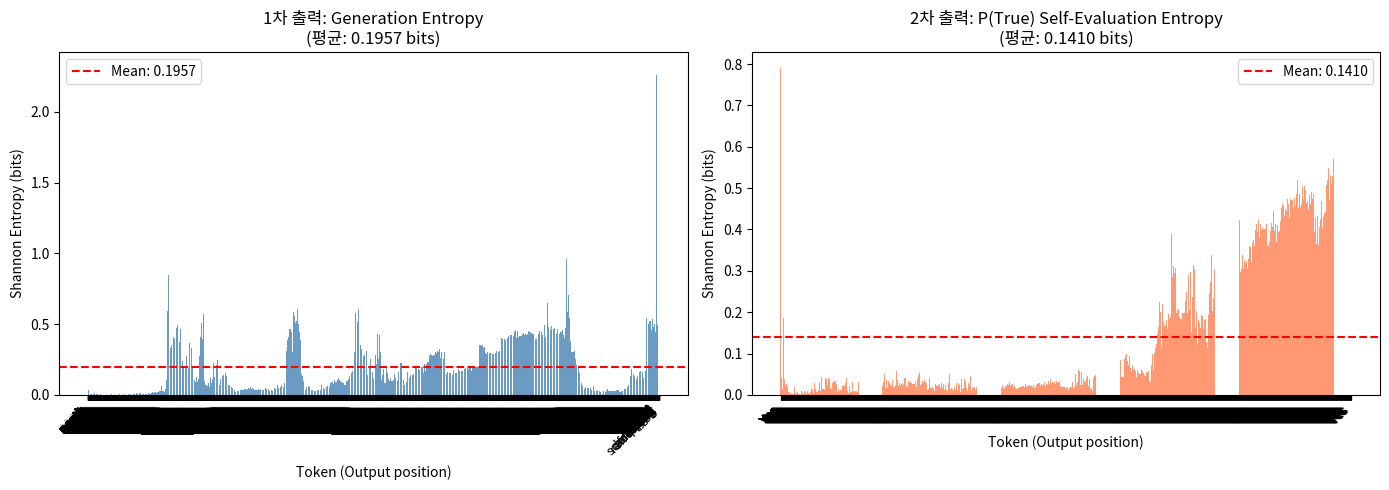

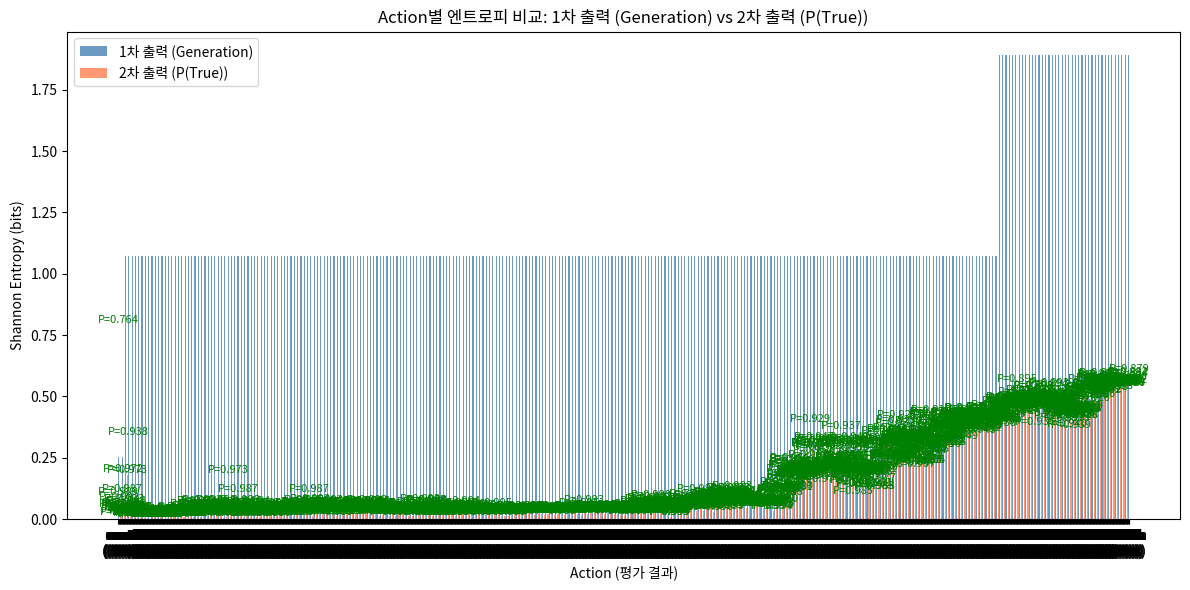


Action별 엔트로피 비교 테이블
Action          평가     1차 Entropy   2차 Entropy   P(True)    차이        
--------------------------------------------------------------------------------
east            Yes    0.2530       0.7893       0.7642     +0.5363
east             Yes   0.2530       0.0881       0.9893     -0.1649
east             Yes   0.2530       0.0680       0.9919     -0.1849
east             Yes   0.2530       0.0409       0.9956     -0.2121
east             Yes   0.2530       0.0086       0.9993     -0.2444
east             Yes   0.2530       0.0378       0.9960     -0.2151
east             Yes   0.2530       0.0148       0.9987     -0.2382
east             Yes   0.2530       0.0466       0.9948     -0.2063
east             Yes   0.2530       0.1021       0.9867     -0.1508
north            Yes   1.0732       0.1855       0.9718     -0.8877
north            Yes   1.0732       0.0600       0.9930     -1.0132
north            Yes   1.0732       0.0279       0.9972     -1.0452
north      

In [21]:
"""
P(True) 기법 테스트 코드
Reference: "Language Models (Mostly) Know What They Know" (Kadavath et al., Anthropic, 2022)

- 1차 출력: Action sequence 생성 및 파싱
- 2차 출력: Self-evaluation ("Is the above answer correct?") 질문
- P(True): "Yes" / "True" 토큰의 logprob을 신뢰도로 사용
- 비교: 생성 시점 entropy vs P(True) entropy
"""

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# ============================================
# 실험 설정
# ============================================
image_path = "./minigrid_debug.png"

system_prompt = """
## ACTION SPACE (FUNDAMENTALS)
- "north" : Move North (Top)
- "south" : Move South (Bottom)
- "west" : Move West (Left)
- "east" : Move East (Right)
- "pickup:north" / "pickup:south" / "pickup:west" / "pickup:east" : Pick up object in the specified direction
- "drop" : Drop object
- "toggle" : Toggle/interact

## OUTPUT FORMAT (STRICTLY IMPORTANT) 
<action1> <action2> <action3> <action4>

## MOVEMENT RULES
- follow user prompt STRICTLY
- follow output action sequence format strictly (including sequence length)
"""
# - follow user prompt as much as possible
# - if user prompt is not clear, do random movement

user_prompt = "move toward red pineapple"

# ============================================
# 1단계: Action Sequence 생성 (1차 출력)
# ============================================
print("=" * 60)
print("1단계: Action Sequence 생성")
print("=" * 60)

image = Image.open(image_path)
print(f"이미지 로드 완료: {image_path} ({image.size[0]}x{image.size[1]})")

# 1차 응답 생성
response_1st = client.models.generate_content(
    model=MODEL_ID,
    contents=[user_prompt, image],
    config=genai.types.GenerateContentConfig(
        system_instruction=system_prompt,
        response_logprobs=True,
        logprobs=5,
        temperature=0.5,
        thinking_config=genai.types.ThinkingConfig(thinking_budget=0)
    )
)

# 1차 출력 파싱
output_text_1st = response_1st.candidates[0].content.parts[0].text.strip()
action_list = output_text_1st.split()  # 공백으로 분리하여 action list 생성

print(f"\n[1차 출력 - Raw]: {output_text_1st}")
print(f"[1차 출력 - Parsed Action List]: {action_list}")

# 1차 출력의 토큰별 엔트로피 계산
logprobs_result_1st = response_1st.candidates[0].logprobs_result
entropies_1st = []
tokens_1st = []

for i, chosen in enumerate(logprobs_result_1st.chosen_candidates):
    tokens_1st.append(chosen.token)
    
    if i < len(logprobs_result_1st.top_candidates):
        top_candidates = logprobs_result_1st.top_candidates[i]
        log_probs = np.array([cand.log_probability for cand in top_candidates.candidates])
        
        # log-sum-exp 정규화
        log_sum_exp = np.log(np.sum(np.exp(log_probs)))
        normalized_log_probs = log_probs - log_sum_exp
        probs = np.exp(normalized_log_probs)
        
        # Shannon 엔트로피
        entropy = -np.sum([p * np.log2(p) if p > 0 else 0 for p in probs])
        entropies_1st.append(entropy)
    else:
        entropies_1st.append(0.0)

print(f"\n[1차 출력 - 평균 엔트로피]: {np.mean(entropies_1st):.4f} bits")

# ============================================
# 2단계: P(True) Self-Evaluation (2차 출력)
# ============================================
print("\n" + "=" * 60)
print("2단계: P(True) Self-Evaluation")
print("=" * 60)

# Self-evaluation 프롬프트 구성
# action 개수에 맞게 Yes/No 출력 형식 생성
num_actions = len(action_list)
yes_no_format = " ".join(["<Yes/No>"] * num_actions)
action_numbered = "\n".join([f"  {i+1}. {action}" for i, action in enumerate(action_list)])

self_eval_system_prompt = f"""
You are evaluating whether EACH action in a proposed sequence is correct for a given task.
For each action, answer with "Yes" (correct) or "No" (incorrect).
Output format: exactly {num_actions} answers separated by space.
Example: Yes Yes No Yes
"""

self_eval_user_prompt = f"""
## Original Task
User command: "{user_prompt}"

## Proposed Action Sequence ({num_actions} actions)
{action_numbered}

## Question
Given the image and the user command, evaluate EACH action individually.
Is each action correct and appropriate for accomplishing the task?

Output exactly {num_actions} answers (Yes or No), one for each action, separated by space:
Format: {yes_no_format}
Answer:
"""

print(f"[Self-Evaluation Prompt]:\n{self_eval_user_prompt}")
print(f"[Expected output format]: {num_actions} Yes/No answers")

# 2차 응답 생성 (Self-evaluation)
response_2nd = client.models.generate_content(
    model=MODEL_ID,
    contents=[self_eval_user_prompt, image],
    config=genai.types.GenerateContentConfig(
        system_instruction=self_eval_system_prompt,
        response_logprobs=True,
        logprobs=5,
        temperature=0.5,  # Deterministic for evaluation
        thinking_config=genai.types.ThinkingConfig(thinking_budget=0)
    )
)

output_text_2nd = response_2nd.candidates[0].content.parts[0].text.strip()
print(f"\n[2차 출력 - Self-Evaluation 결과]: {output_text_2nd}")

# P(True) 계산: 각 action에 대한 Yes/No 토큰의 logprob 추출
logprobs_result_2nd = response_2nd.candidates[0].logprobs_result
entropies_2nd = []
tokens_2nd = []

# 각 action별 P(True) 저장
p_true_per_action = []  # (action_idx, token, logprob, prob, entropy)
action_eval_idx = 0  # 현재 평가 중인 action index

for i, chosen in enumerate(logprobs_result_2nd.chosen_candidates):
    token = chosen.token
    tokens_2nd.append(token)
    
    if i < len(logprobs_result_2nd.top_candidates):
        top_candidates = logprobs_result_2nd.top_candidates[i]
        log_probs = np.array([cand.log_probability for cand in top_candidates.candidates])
        candidate_tokens = [cand.token for cand in top_candidates.candidates]
        
        # log-sum-exp 정규화
        log_sum_exp = np.log(np.sum(np.exp(log_probs)))
        normalized_log_probs = log_probs - log_sum_exp
        probs = np.exp(normalized_log_probs)
        
        # Shannon 엔트로피
        entropy = -np.sum([p * np.log2(p) if p > 0 else 0 for p in probs])
        entropies_2nd.append(entropy)
        
        # "Yes" 또는 "No" 토큰 발견 시 해당 action의 P(True) 저장
        if token.lower().strip() in ["yes", "no", "true", "false"] and action_eval_idx < num_actions:
            logprob = chosen.log_probability
            prob = np.exp(logprob)
            is_yes = token.lower().strip() in ["yes", "true"]
            
            p_true_per_action.append({
                'action_idx': action_eval_idx,
                'action': action_list[action_eval_idx] if action_eval_idx < len(action_list) else "N/A",
                'token': token,
                'logprob': logprob,
                'prob': prob,
                'entropy': entropy,
                'is_yes': is_yes,
                'top_candidates': list(zip(candidate_tokens, log_probs.tolist(), probs.tolist()))
            })
            
            print(f"\n[Action {action_eval_idx + 1}] '{action_list[action_eval_idx] if action_eval_idx < len(action_list) else 'N/A'}'")
            print(f"  평가: '{token}', Logprob: {logprob:.4f}, Prob: {prob:.4f}, Entropy: {entropy:.4f}")
            print(f"  Top-5 candidates:")
            for j, (t, lp, p) in enumerate(zip(candidate_tokens, log_probs, probs)):
                marker = " <--" if t.lower().strip() == token.lower().strip() else ""
                print(f"    {j+1}. '{t}': logprob={lp:.4f}, prob={p:.4f}{marker}")
            
            action_eval_idx += 1
    else:
        entropies_2nd.append(0.0)

print(f"\n[2차 출력 - 평균 엔트로피]: {np.mean(entropies_2nd):.4f} bits")
print(f"[평가된 action 수]: {len(p_true_per_action)} / {num_actions}")

# P(True) 평균 계산 (Yes/True 토큰들의 확률 평균)
p_true_prob = None
p_true_logprob = None
if p_true_per_action:
    yes_probs = [p['prob'] for p in p_true_per_action if p['is_yes']]
    yes_logprobs = [p['logprob'] for p in p_true_per_action if p['is_yes']]
    if yes_probs:
        p_true_prob = np.mean(yes_probs)
        p_true_logprob = np.mean(yes_logprobs)

# ============================================
# 3단계: 결과 비교 및 시각화
# ============================================
print("\n" + "=" * 60)
print("3단계: 결과 비교")
print("=" * 60)

# 요약 통계
print(f"\n[비교 요약]")
print(f"  1차 출력 (Generation):")
print(f"    - Action Sequence: {output_text_1st}")
print(f"    - 토큰 수: {len(tokens_1st)}")
print(f"    - 평균 엔트로피: {np.mean(entropies_1st):.4f} bits")
print(f"    - 최대 엔트로피: {np.max(entropies_1st):.4f} bits")
print(f"    - 최소 엔트로피: {np.min(entropies_1st):.4f} bits")

print(f"\n  2차 출력 (Self-Evaluation):")
print(f"    - 응답: {output_text_2nd}")
print(f"    - 토큰 수: {len(tokens_2nd)}")
print(f"    - 평균 엔트로피: {np.mean(entropies_2nd):.4f} bits")
if p_true_prob is not None:
    print(f"    - P(True/Yes): {p_true_prob:.4f}")
    print(f"    - P(True/Yes) Logprob: {p_true_logprob:.4f}")

# 시각화 1: 전체 토큰별 엔트로피
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1차 출력 엔트로피
ax1 = axes[0]
ax1.bar(range(len(tokens_1st)), entropies_1st, color='steelblue', alpha=0.8)
ax1.set_xticks(range(len(tokens_1st)))
ax1.set_xticklabels(tokens_1st, rotation=45, ha='right', fontsize=9)
ax1.set_xlabel('Token (Output position)')
ax1.set_ylabel('Shannon Entropy (bits)')
ax1.set_title(f'1차 출력: Generation Entropy\n(평균: {np.mean(entropies_1st):.4f} bits)')
ax1.axhline(y=np.mean(entropies_1st), color='red', linestyle='--', label=f'Mean: {np.mean(entropies_1st):.4f}')
ax1.legend()

# 2차 출력 엔트로피
ax2 = axes[1]
colors = ['coral' if t.lower().strip() in ['yes', 'no', 'true', 'false'] else 'steelblue' for t in tokens_2nd]
ax2.bar(range(len(tokens_2nd)), entropies_2nd, color=colors, alpha=0.8)
ax2.set_xticks(range(len(tokens_2nd)))
ax2.set_xticklabels(tokens_2nd, rotation=45, ha='right', fontsize=9)
ax2.set_xlabel('Token (Output position)')
ax2.set_ylabel('Shannon Entropy (bits)')
ax2.set_title(f'2차 출력: P(True) Self-Evaluation Entropy\n(평균: {np.mean(entropies_2nd):.4f} bits)')
ax2.axhline(y=np.mean(entropies_2nd), color='red', linestyle='--', label=f'Mean: {np.mean(entropies_2nd):.4f}')
ax2.legend()

plt.tight_layout()
plt.savefig('./p_true_entropy_comparison_all.png', dpi=150, bbox_inches='tight')
plt.show()

# 시각화 2: Action별 엔트로피 직접 비교 (1차 vs 2차)
if len(p_true_per_action) > 0:
    fig2, ax3 = plt.subplots(figsize=(12, 6))
    
    # 1차 출력에서 action 토큰만 추출하여 엔트로피 계산
    # action_list와 매칭되는 1차 출력 토큰의 엔트로피 추출
    entropies_1st_actions = []
    for action in action_list:
        # 1차 출력 토큰에서 해당 action을 찾음
        found = False
        for idx, token in enumerate(tokens_1st):
            if token.lower().strip() == action.lower().strip():
                entropies_1st_actions.append(entropies_1st[idx])
                found = True
                break
        if not found:
            entropies_1st_actions.append(0.0)  # 못 찾은 경우
    
    # 2차 출력 (P(True)) 엔트로피
    entropies_2nd_actions = [p['entropy'] for p in p_true_per_action]
    p_true_probs = [p['prob'] for p in p_true_per_action]
    eval_tokens = [p['token'] for p in p_true_per_action]
    
    # 비교할 수 있는 최소 길이
    min_len = min(len(action_list), len(entropies_1st_actions), len(entropies_2nd_actions))
    
    x = np.arange(min_len)
    width = 0.35
    
    bars1 = ax3.bar(x - width/2, entropies_1st_actions[:min_len], width, label='1차 출력 (Generation)', color='steelblue', alpha=0.8)
    bars2 = ax3.bar(x + width/2, entropies_2nd_actions[:min_len], width, label='2차 출력 (P(True))', color='coral', alpha=0.8)
    
    # X축 라벨: action + 평가 결과
    x_labels = [f"{action_list[i]}\n({eval_tokens[i]})" for i in range(min_len)]
    ax3.set_xticks(x)
    ax3.set_xticklabels(x_labels, fontsize=10)
    ax3.set_xlabel('Action (평가 결과)')
    ax3.set_ylabel('Shannon Entropy (bits)')
    ax3.set_title('Action별 엔트로피 비교: 1차 출력 (Generation) vs 2차 출력 (P(True))')
    ax3.legend()
    
    # P(True) 확률 표시
    for i, (bar, prob, token) in enumerate(zip(bars2, p_true_probs[:min_len], eval_tokens[:min_len])):
        color = 'green' if token.lower().strip() in ['yes', 'true'] else 'red'
        ax3.annotate(f'P={prob:.3f}', 
                    xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    ha='center', va='bottom', fontsize=8, color=color)
    
    plt.tight_layout()
    plt.savefig('./p_true_entropy_comparison_actions.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 수치 비교 테이블 출력
    print("\n" + "=" * 80)
    print("Action별 엔트로피 비교 테이블")
    print("=" * 80)
    print(f"{'Action':<15} {'평가':<6} {'1차 Entropy':<12} {'2차 Entropy':<12} {'P(True)':<10} {'차이':<10}")
    print("-" * 80)
    for i in range(min_len):
        diff = entropies_2nd_actions[i] - entropies_1st_actions[i]
        is_yes = p_true_per_action[i]['is_yes']
        print(f"{action_list[i]:<15} {eval_tokens[i]:<6} {entropies_1st_actions[i]:<12.4f} {entropies_2nd_actions[i]:<12.4f} {p_true_probs[i]:<10.4f} {diff:+.4f}")
    print("-" * 80)
    print(f"{'평균':<15} {'':<6} {np.mean(entropies_1st_actions[:min_len]):<12.4f} {np.mean(entropies_2nd_actions[:min_len]):<12.4f} {np.mean(p_true_probs[:min_len]):<10.4f} {np.mean(entropies_2nd_actions[:min_len]) - np.mean(entropies_1st_actions[:min_len]):+.4f}")
else:
    print("\n[경고] P(True) 평가 결과가 없습니다. 프롬프트나 모델 출력을 확인해주세요.")

print(f"\n그래프 저장 완료: ./p_true_entropy_comparison.png")

1단계: Action Sequence 생성
Task: move toward hatsune miku
Generated Action Sequence: up up right right down right right down down left left left down left down left left left down down left left down down down left down down left down down left down down down down down down down down down down down down left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left left lef

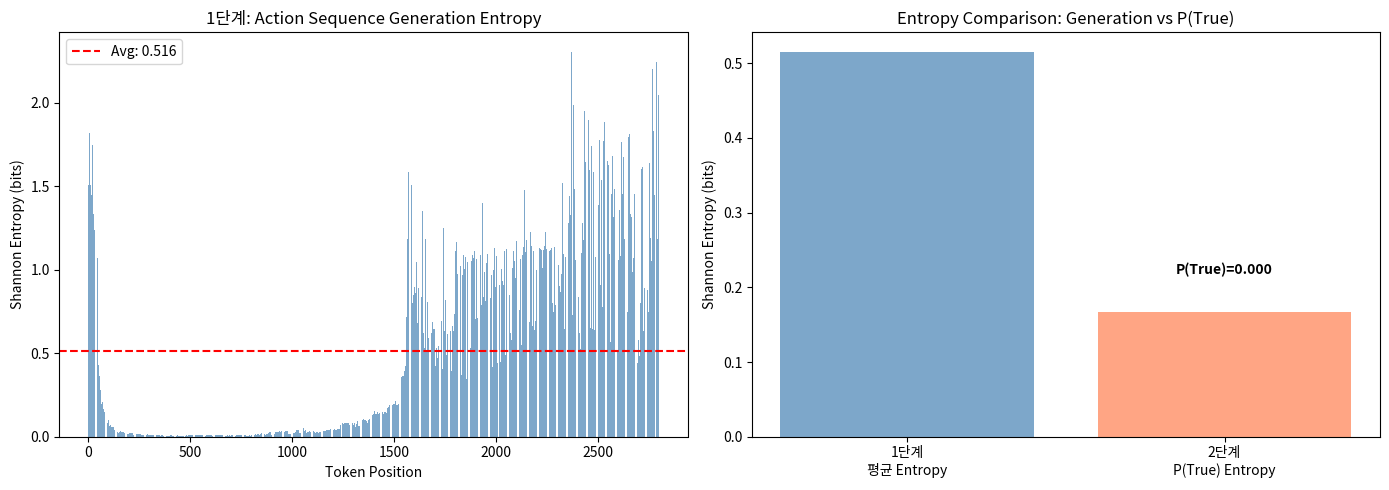


결과 저장: p_true_original_method.png


In [19]:
## P(True) 방법론 (Kadavath et al., 2022 논문 원본 방식)
# 
# 핵심: 전체 답변에 대해 "한 번의" True/False 평가
# 1차: Action sequence 생성
# 2차: "Is the above answer correct?" → "True" 토큰의 확률 = P(True)

import numpy as np
import matplotlib.pyplot as plt

# ============================================
# 설정
# ============================================
system_prompt = """You are a robot navigation assistant. 
Given a task, output a sequence of actions to complete it.
Available actions: up, down, left, right, pickup:north, pickup:south, pickup:east, pickup:west, drop
Output only the action sequence, separated by spaces."""

# 테스트용 task
# task = "Go to the red apple and pick it up. The apple is located 2 cells up and 1 cell left from your current position."
task = "move toward hatsune miku"
# ============================================
# 1단계: Action Sequence 생성
# ============================================
print("=" * 60)
print("1단계: Action Sequence 생성")
print("=" * 60)

response_1 = client.models.generate_content(
    model=MODEL_ID,
    contents=task,
    config=genai.types.GenerateContentConfig(
        system_instruction=system_prompt,
        response_logprobs=True,
        logprobs=5,
        temperature=1.0,
        thinking_config=genai.types.ThinkingConfig(thinking_budget=0)
    )
)

# 생성된 action sequence
action_sequence = response_1.candidates[0].content.parts[0].text.strip()
print(f"Task: {task}")
print(f"Generated Action Sequence: {action_sequence}")

# 1단계 토큰별 entropy 계산
logprobs_1 = response_1.candidates[0].logprobs_result
tokens_1 = []
entropies_1 = []

for i, chosen in enumerate(logprobs_1.chosen_candidates):
    tokens_1.append(chosen.token)
    
    if i < len(logprobs_1.top_candidates):
        top_cands = logprobs_1.top_candidates[i]
        log_probs = np.array([c.log_probability for c in top_cands.candidates])
        # log-sum-exp 정규화
        log_sum_exp = np.log(np.sum(np.exp(log_probs - np.max(log_probs)))) + np.max(log_probs)
        probs = np.exp(log_probs - log_sum_exp)
        entropy = -np.sum([p * np.log2(p) if p > 0 else 0 for p in probs])
        entropies_1.append(entropy)
    else:
        entropies_1.append(0.0)

avg_entropy_1 = np.mean(entropies_1) if entropies_1 else 0
print(f"\n1단계 평균 Entropy: {avg_entropy_1:.4f} bits")

# ============================================
# 2단계: P(True) Self-Evaluation (논문 원본 방식)
# ============================================
print("\n" + "=" * 60)
print("2단계: P(True) Self-Evaluation")
print("=" * 60)

# 논문 원본 프롬프트 형식
eval_prompt = f"""Task: {task}

Proposed Action Sequence: {action_sequence}

Is the above action sequence correct for completing the task? Answer with only "True" or "False":"""

response_2 = client.models.generate_content(
    model=MODEL_ID,
    contents=eval_prompt,
    config=genai.types.GenerateContentConfig(
        response_logprobs=True,
        logprobs=5,
        temperature=1.0,
        thinking_config=genai.types.ThinkingConfig(thinking_budget=0)
    )
)

# 2단계 결과 분석
eval_answer = response_2.candidates[0].content.parts[0].text.strip()
print(f"Self-Evaluation Answer: {eval_answer}")

# 첫 번째 토큰의 logprob에서 P(True) 추출
logprobs_2 = response_2.candidates[0].logprobs_result
p_true = None
p_false = None
first_token_entropy = 0.0

if logprobs_2.top_candidates and len(logprobs_2.top_candidates) > 0:
    first_top_cands = logprobs_2.top_candidates[0]
    
    # 첫 번째 토큰의 entropy 계산
    log_probs = np.array([c.log_probability for c in first_top_cands.candidates])
    log_sum_exp = np.log(np.sum(np.exp(log_probs - np.max(log_probs)))) + np.max(log_probs)
    probs = np.exp(log_probs - log_sum_exp)
    first_token_entropy = -np.sum([p * np.log2(p) if p > 0 else 0 for p in probs])
    
    # True/False 토큰 확률 찾기
    for cand in first_top_cands.candidates:
        token_lower = cand.token.strip().lower()
        prob = np.exp(cand.log_probability)
        if token_lower == "true":
            p_true = prob
        elif token_lower == "false":
            p_false = prob

print(f"\nP(True) = {p_true if p_true else 'Not in top-5'}")
print(f"P(False) = {p_false if p_false else 'Not in top-5'}")
print(f"2단계 첫 토큰 Entropy: {first_token_entropy:.4f} bits")

# ============================================
# 결과 비교 및 시각화
# ============================================
print("\n" + "=" * 60)
print("비교 결과")
print("=" * 60)
print(f"1단계 평균 Entropy: {avg_entropy_1:.4f} bits")
print(f"2단계 P(True) Entropy: {first_token_entropy:.4f} bits")
print(f"Entropy 차이: {avg_entropy_1 - first_token_entropy:.4f} bits")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1단계: 토큰별 entropy
ax1 = axes[0]
ax1.bar(range(len(tokens_1)), entropies_1, color='steelblue', alpha=0.7)
ax1.axhline(y=avg_entropy_1, color='red', linestyle='--', label=f'Avg: {avg_entropy_1:.3f}')
ax1.set_xlabel('Token Position')
ax1.set_ylabel('Shannon Entropy (bits)')
ax1.set_title('1단계: Action Sequence Generation Entropy')
ax1.legend()

# 2단계: P(True) 비교
ax2 = axes[1]
labels = ['1단계\n평균 Entropy', '2단계\nP(True) Entropy']
values = [avg_entropy_1, first_token_entropy]
colors = ['steelblue', 'coral']
bars = ax2.bar(labels, values, color=colors, alpha=0.7)

# P(True) 값 표시
if p_true is not None:
    ax2.text(1, first_token_entropy + 0.05, f'P(True)={p_true:.3f}', 
             ha='center', fontsize=10, fontweight='bold')

ax2.set_ylabel('Shannon Entropy (bits)')
ax2.set_title('Entropy Comparison: Generation vs P(True)')

plt.tight_layout()
plt.savefig('p_true_original_method.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n결과 저장: p_true_original_method.png")

Verbalized Calibration for Action Entropy
[User Command]: move toward red apple
[Temperature]: 0.7
[Image]: ./minigrid_debug.png (448x448)

----------------------------------------------------------------------
[Top-5 Action Scenarios (Verbalized Confidence)]
----------------------------------------------------------------------
  Rank 1: ['east', 'east', 'north']
          Probability: 0.4000 | Justification: Direct path to red apple
  Rank 2: ['east', 'north', 'east']
          Probability: 0.2000 | Justification: Alternate path to red apple
  Rank 3: ['north', 'east', 'east']
          Probability: 0.1500 | Justification: Another path to red apple
  Rank 4: ['east', 'north', 'north']
          Probability: 0.1500 | Justification: Moves towards general area
  Rank 5: ['north', 'north', 'east']
          Probability: 0.1000 | Justification: Less direct but moves towards

----------------------------------------------------------------------
[Reasoning]: Move towards the closest red ap

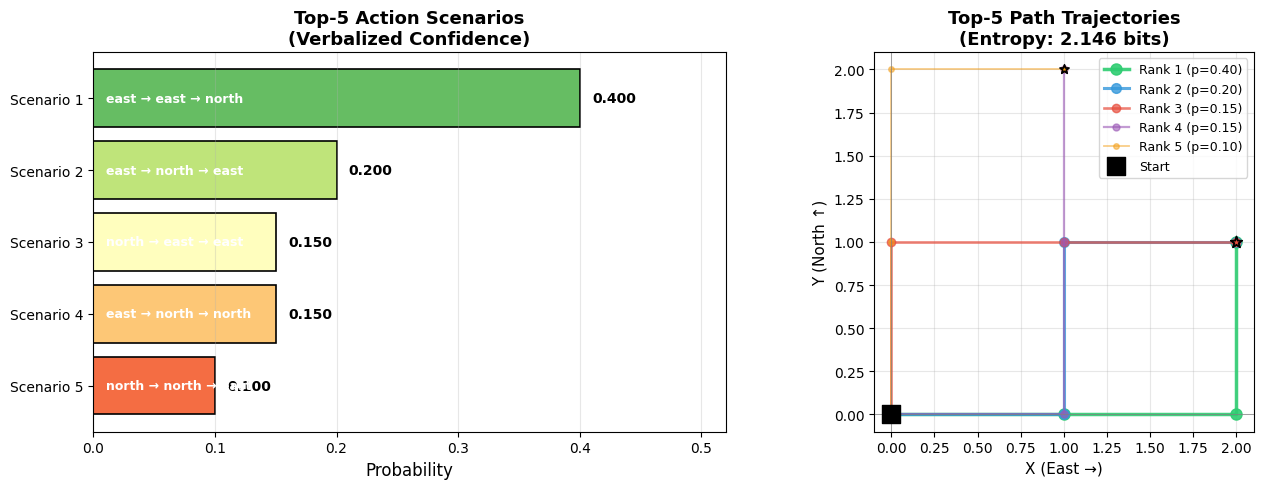


[INFO] 시각화 저장 완료: ./verbalized_calibration_visualization.png


In [31]:
"""
=============================================================================
PoC: Verbalized Calibration for Action Entropy (Tian et al., 2023 기반)
=============================================================================
핵심 원칙:
1. 시나리오 기반 확률 할당 (Verb. 1S Top-k): 3-step 경로를 "상위 5가지 경로 시나리오"로 정의
2. 언어화된 신뢰도 추출 (Verbalized Confidence): 모델이 직접 수치적 확률을 텍스트로 출력
3. 추론과 확신의 분리: reasoning은 간결하게, 확률은 별도로 부여

특징:
- Top-5 후보군 출력
- 각 시나리오는 3-step action path
- Reasoning 간결하게 (50자 이내)
- 모든 확률의 합 = 1.0 (엄격한 제약)
=============================================================================
"""

import numpy as np
import json
from PIL import Image
from google import genai
from google.oauth2 import service_account
from typing import Optional

# ============================================
# API 설정 (기존 client가 없는 경우에만 실행)
# ============================================
try:
    client
except NameError:
    KEY_PATH = "/home/syaro/stan_GCP_API.json"
    PROJECT_ID = "composed-hash-485105-k5"
    LOCATION = "us-central1"
    
    scopes = ['https://www.googleapis.com/auth/cloud-platform']
    credentials = service_account.Credentials.from_service_account_file(
        KEY_PATH, scopes=scopes
    )
    
    client = genai.Client(
        vertexai=True,
        project=PROJECT_ID,
        location=LOCATION,
        credentials=credentials
    )
    print("[INFO] Gemini Client 초기화 완료")

MODEL_ID = "gemini-2.5-flash"

# ============================================
# Verbalized Calibration 프롬프트 정의
# ============================================

SYSTEM_PROMPT_VERBALIZED_CALIBRATION = """
## ROLE
You are a calibrated robot controller. You should follow the user's command.


## WORLD MODEL
- 2D grid world, top-down view, north-up orientation
- Cells: EMPTY, WALL, TARGET, OBJECT, AGENT

## ACTION SPACE
- "north" / "south" / "west" / "east": Movement directions




## OUTPUT FORMAT
- Output ONLY valid JSON
- "path": exactly 3 actions
- "probability": float 0.0-1.0, sum MUST equal 1.0
- "justification": ≤30 chars (explain why this path)
- "reasoning": ≤50 chars (how you interpreted the command)

## OUTPUT SCHEMA
{
  "action_scenarios": [
    {"path": ["action1", "action2", "action3"], "probability": 0.XX, "justification": "reason"},
    {"path": ["action1", "action2", "action3"], "probability": 0.XX, "justification": "reason"},
    {"path": ["action1", "action2", "action3"], "probability": 0.XX, "justification": "reason"},
    {"path": ["action1", "action2", "action3"], "probability": 0.XX, "justification": "reason"},
    {"path": ["action1", "action2", "action3"], "probability": 0.XX, "justification": "reason"}
  ],
  "reasoning": "How I interpreted the command (≤50 chars)"
}
"""

# ============================================
# JSON Schema for Strict Output Format
# ============================================
RESPONSE_SCHEMA = {
    "type": "object",
    "properties": {
        "action_scenarios": {
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                    "path": {
                        "type": "array",
                        "items": {"type": "string"},
                        "minItems": 3,
                        "maxItems": 3
                    },
                    "probability": {
                        "type": "number",
                        "minimum": 0.0,
                        "maximum": 1.0
                    },
                    "justification": {"type": "string"}
                },
                "required": ["path", "probability", "justification"]
            },
            "minItems": 5,
            "maxItems": 5
        },
        "reasoning": {"type": "string"}
    },
    "required": ["action_scenarios", "reasoning"]
}


def calculate_action_entropy(probabilities: list) -> float:
    """Shannon Entropy 계산 (bits)"""
    probs = np.array(probabilities)
    probs = probs[probs > 0]  # 0 제외
    if len(probs) == 0:
        return 0.0
    return -np.sum(probs * np.log2(probs))


def normalize_probabilities(probabilities: list) -> list:
    """확률 합이 1이 되도록 정규화"""
    total = sum(probabilities)
    if total == 0:
        return [1.0 / len(probabilities)] * len(probabilities)
    return [p / total for p in probabilities]


def run_verbalized_calibration(
    user_command: str,
    image_path: Optional[str] = None,
    image: Optional[Image.Image] = None,
    temperature: float = 0.3,  # 낮은 temperature로 더 결정적인 응답
    verbose: bool = True
) -> dict:
    """
    Verbalized Calibration을 통한 Action Entropy 추출
    
    Args:
        user_command: 사용자 명령어
        image_path: 이미지 파일 경로 (image와 둘 중 하나 필수)
        image: PIL Image 객체 (image_path와 둘 중 하나 필수)
        temperature: 생성 temperature (낮을수록 결정적, 기본 0.3)
        verbose: 상세 출력 여부
    
    Returns:
        dict: {
            'scenarios': list of scenarios,
            'probabilities': list of probabilities,
            'entropy': float (bits),
            'reasoning': str,
            'raw_response': str
        }
    """
    # 이미지 로드
    if image is None:
        if image_path is None:
            raise ValueError("image_path 또는 image 중 하나는 필수입니다.")
        image = Image.open(image_path)
    
    if verbose:
        print("=" * 70)
        print("Verbalized Calibration for Action Entropy")
        print("=" * 70)
        print(f"[User Command]: {user_command}")
        print(f"[Temperature]: {temperature}")
        if image_path:
            print(f"[Image]: {image_path} ({image.size[0]}x{image.size[1]})")
    
    # 명령어를 명시적으로 강조하여 전달
    formatted_prompt = f"""## USER COMMAND (MUST FOLLOW):
{user_command}

## INSTRUCTION:
Execute the above command. Generate 5 action scenarios that follow this command.
The first scenario should directly execute the command with highest probability."""

    # Gemini API 호출 (response_schema 제거 - 자유로운 확률 분포 허용)
    response = client.models.generate_content(
        model=MODEL_ID,
        contents=[formatted_prompt, image],
        config=genai.types.GenerateContentConfig(
            system_instruction=SYSTEM_PROMPT_VERBALIZED_CALIBRATION,
            response_mime_type="application/json",  # JSON 형식만 유지, 스키마 강제 제거
            # response_schema=RESPONSE_SCHEMA,  # 제거: 5개 시나리오 강제가 확률 분포에 영향
            temperature=temperature,
            thinking_config=genai.types.ThinkingConfig(thinking_budget=0)
        )
    )
    
    raw_output = response.candidates[0].content.parts[0].text.strip()
    
    # JSON 파싱
    try:
        result = json.loads(raw_output)
    except json.JSONDecodeError as e:
        print(f"[ERROR] JSON 파싱 실패: {e}")
        print(f"[Raw Output]: {raw_output}")
        return None
    
    # 시나리오 및 확률 추출
    scenarios = result.get("action_scenarios", [])
    probabilities = [s.get("probability", 0.0) for s in scenarios]
    reasoning = result.get("reasoning", "")
    
    # 확률 정규화 (합이 1이 아닌 경우 보정)
    prob_sum = sum(probabilities)
    if abs(prob_sum - 1.0) > 0.01:  # 1% 이상 오차
        if verbose:
            print(f"[WARNING] 확률 합 {prob_sum:.4f} → 1.0으로 정규화")
        probabilities = normalize_probabilities(probabilities)
    
    # Action Entropy 계산
    entropy = calculate_action_entropy(probabilities)
    
    # 결과 출력
    if verbose:
        print("\n" + "-" * 70)
        print("[Top-5 Action Scenarios (Verbalized Confidence)]")
        print("-" * 70)
        for i, scenario in enumerate(scenarios):
            path = scenario.get("path", [])
            prob = probabilities[i] if i < len(probabilities) else 0.0
            justification = scenario.get("justification", "")
            print(f"  Rank {i+1}: {path}")
            print(f"          Probability: {prob:.4f} | Justification: {justification}")
        
        print("\n" + "-" * 70)
        print(f"[Reasoning]: {reasoning}")
        print(f"[Probability Sum]: {sum(probabilities):.4f}")
        print(f"[Action Entropy]: {entropy:.4f} bits")
        print("-" * 70)
        
        # Entropy 해석
        max_entropy = np.log2(5)  # 5개 균등 분포 시 최대 엔트로피
        uncertainty_ratio = entropy / max_entropy
        if uncertainty_ratio < 0.3:
            confidence_level = "HIGH (확신)"
        elif uncertainty_ratio < 0.6:
            confidence_level = "MEDIUM (보통)"
        else:
            confidence_level = "LOW (불확실)"
        print(f"[Confidence Level]: {confidence_level} (uncertainty ratio: {uncertainty_ratio:.2f})")
        print("=" * 70)
    
    return {
        'scenarios': scenarios,
        'probabilities': probabilities,
        'entropy': entropy,
        'reasoning': reasoning,
        'raw_response': raw_output,
        'normalized': abs(prob_sum - 1.0) > 0.01
    }


# ============================================
# PoC 실행
# ============================================
if __name__ == "__main__" or True:  # 노트북에서 항상 실행
    
    # 테스트 이미지 경로 (절대 경로 사용)
    import os
    NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))
    test_image_path = "./minigrid_debug.png"
    
    # 이미지 로드 및 실험 실행
    result = run_verbalized_calibration(
        user_command="move toward red apple",
        image_path=test_image_path,
        temperature=0.7,
        verbose=True
    )
    
    # 결과 요약
    if result:
        print("\n" + "=" * 70)
        print("[실험 결과 요약]")
        print("=" * 70)
        print(f"- 추출된 시나리오 수: {len(result['scenarios'])}")
        print(f"- 확률 분포: {[f'{p:.3f}' for p in result['probabilities']]}")
        print(f"- Action Entropy: {result['entropy']:.4f} bits")
        print(f"- 정규화 적용 여부: {result['normalized']}")
        
        # Entropy 기반 Safety Threshold 예시
        SAFETY_THRESHOLD = 1.5  # bits (튜닝 가능)
        if result['entropy'] > SAFETY_THRESHOLD:
            print(f"\n⚠️  [SAFETY ALERT] Entropy ({result['entropy']:.2f}) > Threshold ({SAFETY_THRESHOLD})")
            print("   → 불확실성이 높음. 추가 확인 또는 정지 권장.")
        else:
            print(f"\n✓  [SAFE] Entropy ({result['entropy']:.2f}) ≤ Threshold ({SAFETY_THRESHOLD})")
            print("   → 확신도 충분. 첫 번째 시나리오 실행 권장.")
        
        # ============================================
        # Visualization: Path & Entropy
        # ============================================
        import matplotlib.pyplot as plt
        import matplotlib.patches as mpatches
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # --- Plot 1: Probability Distribution (Bar Chart) ---
        ax1 = axes[0]
        scenarios = result['scenarios']
        probs = result['probabilities']
        labels = [f"Scenario {i+1}" for i in range(len(probs))]
        colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(probs)))  # Red=Low, Green=High
        
        bars = ax1.barh(labels, probs, color=colors, edgecolor='black', linewidth=1.2)
        ax1.set_xlabel('Probability', fontsize=12)
        ax1.set_title('Top-5 Action Scenarios\n(Verbalized Confidence)', fontsize=13, fontweight='bold')
        ax1.set_xlim(0, max(probs) * 1.3)
        ax1.invert_yaxis()
        
        # 확률값 표시
        for bar, prob in zip(bars, probs):
            ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                     f'{prob:.3f}', va='center', fontsize=10, fontweight='bold')
        
        # Path 텍스트 추가
        for i, (bar, scenario) in enumerate(zip(bars, scenarios)):
            path_str = " → ".join(scenario['path'])
            ax1.text(0.01, bar.get_y() + bar.get_height()/2,
                     path_str, va='center', fontsize=9, color='white', fontweight='bold')
        
        ax1.grid(axis='x', alpha=0.3)
        
        # --- Plot 2: Path Visualization (Simplified Grid) ---
        ax2 = axes[1]
        
        # 방향 벡터 매핑
        direction_map = {
            'north': (0, 1), 'south': (0, -1), 'west': (-1, 0), 'east': (1, 0),
            'pickup:north': (0, 0.5), 'pickup:south': (0, -0.5),
            'pickup:west': (-0.5, 0), 'pickup:east': (0.5, 0),
            'drop': (0, 0), 'toggle': (0, 0)
        }
        
        # Top-5 시나리오 경로 시각화
        colors_path = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6', '#f39c12']  # Green, Blue, Red, Purple, Orange
        start_pos = (0, 0)
        
        for idx, (scenario, color) in enumerate(zip(scenarios, colors_path)):
            path = scenario['path']
            prob = probs[idx]
            
            x, y = start_pos
            positions = [(x, y)]
            
            for action in path:
                action_lower = action.lower()
                if action_lower in direction_map:
                    dx, dy = direction_map[action_lower]
                    x += dx
                    y += dy
                    positions.append((x, y))
            
            # 경로 그리기
            xs, ys = zip(*positions)
            ax2.plot(xs, ys, marker='o', markersize=8 - idx, linewidth=2.5 - idx * 0.3,
                     color=color, alpha=0.9 - idx * 0.1, label=f'Rank {idx+1} (p={prob:.2f})')
            
            # 끝점 마커
            ax2.scatter([xs[-1]], [ys[-1]], s=80 - idx * 10, c=color, marker='*', zorder=10, edgecolors='black')
        
        # 시작점 마커
        ax2.scatter([0], [0], s=150, c='black', marker='s', zorder=15, label='Start')
        
        ax2.set_xlabel('X (East →)', fontsize=11)
        ax2.set_ylabel('Y (North ↑)', fontsize=11)
        ax2.set_title(f'Top-5 Path Trajectories\n(Entropy: {result["entropy"]:.3f} bits)', fontsize=13, fontweight='bold')
        ax2.legend(loc='best', fontsize=9)
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='gray', linewidth=0.5)
        ax2.axvline(x=0, color='gray', linewidth=0.5)
        ax2.set_aspect('equal')
        
        plt.tight_layout()
        plt.savefig('./verbalized_calibration_visualization.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("\n[INFO] 시각화 저장 완료: ./verbalized_calibration_visualization.png")


# ============================================
# 함수화: 반복 실행 + 통계 + Plot
# ============================================
def run_repeated_experiment(
    user_command: str,
    n_runs: int = 5,
    image_path: str = "./minigrid_debug.png",
    temperature: float = 0.3,  # 낮은 temperature로 더 결정적인 응답
    save_plot: bool = True
) -> dict:
    """
    Verbalized Calibration 실험을 N회 반복 실행하고 통계 및 시각화 수행
    
    Args:
        user_command: 사용자 명령어 (Language Command)
        n_runs: 반복 실행 횟수 (default: 5)
        image_path: 이미지 경로
        temperature: 생성 temperature
        save_plot: 플롯 저장 여부
    
    Returns:
        dict: 통계 결과
    """
    print("\n" + "=" * 70)
    print(f"[반복 실험] {n_runs}회 연속 실행 - Mean & STD 분석")
    print(f"[Command]: {user_command}")
    print("=" * 70)
    
    all_entropies = []
    all_probabilities = []
    all_scenarios = []
    
    for run_idx in range(n_runs):
        print(f"\n--- Run {run_idx + 1}/{n_runs} ---")
        
        run_result = run_verbalized_calibration(
            user_command=user_command,
            image_path=image_path,
            temperature=temperature,
            verbose=False
        )
        
        if run_result:
            all_entropies.append(run_result['entropy'])
            all_probabilities.append(run_result['probabilities'])
            all_scenarios.append(run_result['scenarios'])
            print(f"   Entropy: {run_result['entropy']:.4f} bits")
            print(f"   Probs: {[f'{p:.3f}' for p in run_result['probabilities']]}")
        else:
            print(f"   [ERROR] Run {run_idx + 1} failed")
    
    if len(all_entropies) == 0:
        print("[ERROR] 모든 실행 실패")
        return None
    
    # 통계 계산
    all_entropies = np.array(all_entropies)
    all_probabilities = np.array(all_probabilities)
    
    entropy_mean = np.mean(all_entropies)
    entropy_std = np.std(all_entropies)
    prob_means = np.mean(all_probabilities, axis=0)
    prob_stds = np.std(all_probabilities, axis=0)
    
    # 결과 출력
    print("\n" + "=" * 70)
    print("[통계 결과]")
    print("=" * 70)
    print(f"\n📊 Entropy 통계 (N={len(all_entropies)})")
    print(f"   Mean: {entropy_mean:.4f} bits")
    print(f"   STD:  {entropy_std:.4f} bits")
    print(f"   Min:  {np.min(all_entropies):.4f} bits")
    print(f"   Max:  {np.max(all_entropies):.4f} bits")
    
    print(f"\n📊 시나리오별 확률 통계")
    for i in range(len(prob_means)):
        print(f"   Scenario {i+1}: Mean={prob_means[i]:.4f}, STD={prob_stds[i]:.4f}")
    
    # CV 계산
    cv_entropy = entropy_std / entropy_mean if entropy_mean > 0 else 0
    prob_cv = np.mean(prob_stds / (prob_means + 1e-8))
    
    # 안정성 평가
    if cv_entropy < 0.1:
        stability = "HIGH (안정적)"
    elif cv_entropy < 0.3:
        stability = "MEDIUM (보통)"
    else:
        stability = "LOW (불안정)"
    
    print(f"\n📊 안정성 평가")
    print(f"   Entropy CV: {cv_entropy:.4f} → {stability}")
    print(f"   확률분포 CV: {prob_cv:.4f}")
    
    # ============================================
    # 시각화
    # ============================================
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle(f'Command: "{user_command}"', fontsize=14, fontweight='bold', y=1.02)
    
    # --- Plot 1: Entropy over runs ---
    ax1 = axes[0]
    runs = np.arange(1, n_runs + 1)
    ax1.bar(runs, all_entropies, color='steelblue', edgecolor='black', alpha=0.7)
    ax1.axhline(y=entropy_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {entropy_mean:.3f}')
    ax1.fill_between([0.5, n_runs + 0.5], entropy_mean - entropy_std, entropy_mean + entropy_std,
                     alpha=0.2, color='red', label=f'±1 STD: {entropy_std:.3f}')
    ax1.set_xlabel('Run', fontsize=12)
    ax1.set_ylabel('Entropy (bits)', fontsize=12)
    ax1.set_title(f'Entropy per Run\n(Mean={entropy_mean:.3f}, STD={entropy_std:.3f})', fontsize=12, fontweight='bold')
    ax1.set_xticks(runs)
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(axis='y', alpha=0.3)
    
    # --- Plot 2: Probability distribution with error bars ---
    ax2 = axes[1]
    scenario_labels = [f'S{i+1}' for i in range(len(prob_means))]
    x_pos = np.arange(len(prob_means))
    colors_bar = plt.cm.viridis(np.linspace(0.2, 0.8, len(prob_means)))
    
    bars = ax2.bar(x_pos, prob_means, yerr=prob_stds, capsize=5,
                   color=colors_bar, edgecolor='black', alpha=0.8,
                   error_kw={'elinewidth': 2, 'ecolor': 'darkred'})
    ax2.set_xlabel('Scenario Rank', fontsize=12)
    ax2.set_ylabel('Probability', fontsize=12)
    ax2.set_title('Mean Probability by Scenario\n(±1 STD)', fontsize=12, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(scenario_labels)
    ax2.grid(axis='y', alpha=0.3)
    
    for bar, mean, std in zip(bars, prob_means, prob_stds):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                 f'{mean:.2f}', ha='center', fontsize=10, fontweight='bold')
    
    # --- Plot 3: Box plot ---
    ax3 = axes[2]
    bp = ax3.boxplot(all_probabilities, labels=scenario_labels, patch_artist=True)
    
    for patch, color in zip(bp['boxes'], colors_bar):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax3.set_xlabel('Scenario Rank', fontsize=12)
    ax3.set_ylabel('Probability', fontsize=12)
    ax3.set_title(f'Probability Distribution\n(N={n_runs} runs)', fontsize=12, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if save_plot:
        filename = f'./repeated_experiment_{user_command[:20].replace(" ", "_")}.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"\n[INFO] 플롯 저장: {filename}")
    
    plt.show()
    print("=" * 70)
    
    return {
        'command': user_command,
        'n_runs': n_runs,
        'entropies': all_entropies.tolist(),
        'probabilities': all_probabilities.tolist(),
        'scenarios': all_scenarios,
        'stats': {
            'entropy_mean': entropy_mean,
            'entropy_std': entropy_std,
            'entropy_cv': cv_entropy,
            'prob_means': prob_means.tolist(),
            'prob_stds': prob_stds.tolist(),
            'stability': stability
        }
    }



[반복 실험] 5회 연속 실행 - Mean & STD 분석
[Command]: move toward hatsune miku

--- Run 1/5 ---


   Entropy: 2.1219 bits
   Probs: ['0.400', '0.200', '0.200', '0.100', '0.100']

--- Run 2/5 ---
   Entropy: 2.1219 bits
   Probs: ['0.400', '0.200', '0.200', '0.100', '0.100']

--- Run 3/5 ---
   Entropy: 2.1219 bits
   Probs: ['0.400', '0.200', '0.200', '0.100', '0.100']

--- Run 4/5 ---
   Entropy: 2.1219 bits
   Probs: ['0.400', '0.200', '0.200', '0.100', '0.100']

--- Run 5/5 ---
   Entropy: 2.1219 bits
   Probs: ['0.400', '0.200', '0.200', '0.100', '0.100']

[통계 결과]

📊 Entropy 통계 (N=5)
   Mean: 2.1219 bits
   STD:  0.0000 bits
   Min:  2.1219 bits
   Max:  2.1219 bits

📊 시나리오별 확률 통계
   Scenario 1: Mean=0.4000, STD=0.0000
   Scenario 2: Mean=0.2000, STD=0.0000
   Scenario 3: Mean=0.2000, STD=0.0000
   Scenario 4: Mean=0.1000, STD=0.0000
   Scenario 5: Mean=0.1000, STD=0.0000

📊 안정성 평가
   Entropy CV: 0.0000 → HIGH (안정적)
   확률분포 CV: 0.0000


/tmp/ipykernel_817148/3163084869.py:535: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(all_probabilities, labels=scenario_labels, patch_artist=True)



[INFO] 플롯 저장: ./repeated_experiment_move_toward_hatsune_.png


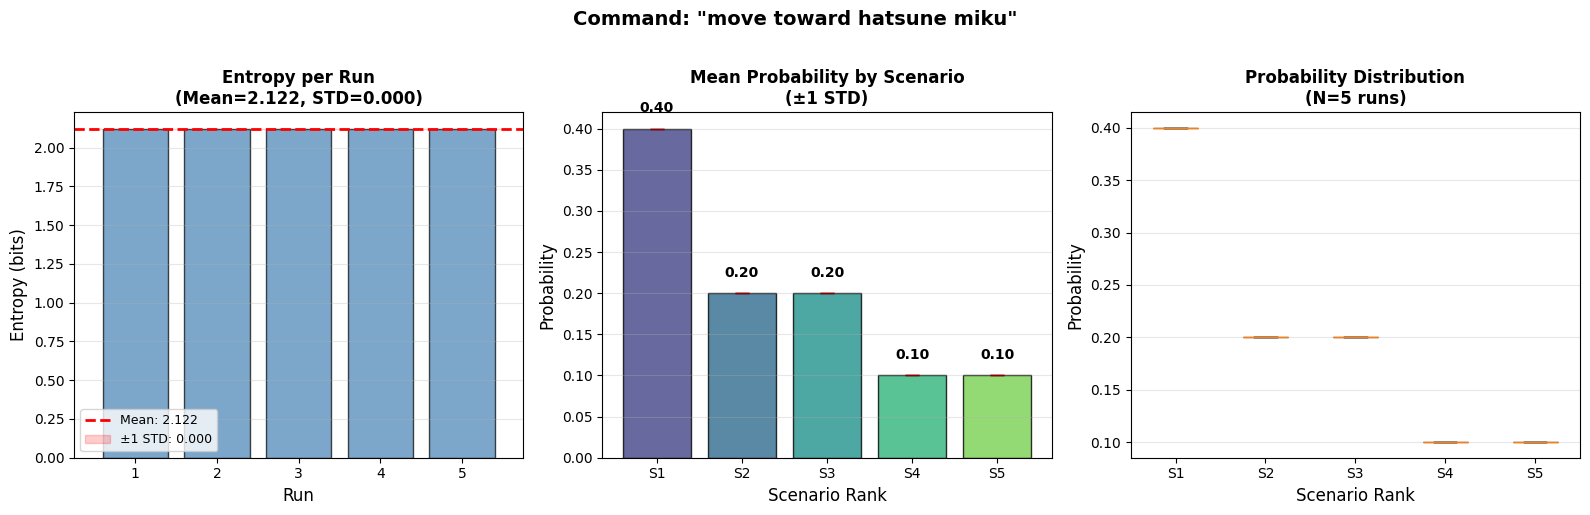

In [30]:
# ============================================
# 반복 실험 실행 예제
# ============================================
# Language Command와 Temperature를 명시적으로 설정

# 예제 1: 명확한 방향 지정 → 높은 확신 기대 (Entropy ≈ 0.5 bits)
stats_result = run_repeated_experiment(
    user_command="move toward hatsune miku",
    n_runs=5,
    temperature=0.2  # 낮은 temperature로 결정적 응답
)

# 예제 2: 모호한 명령 → 낮은 확신 기대 (Entropy ≈ 2.0 bits)
# stats_result = run_repeated_experiment(
#     user_command="do random direction movement",
#     n_runs=5,
#     temperature=0.3
# )

# 예제 3: 목표 기반 명령 → 중간 확신 기대 (Entropy ≈ 1.2 bits)
# stats_result = run_repeated_experiment(
#     user_command="move toward red apple",
#     n_runs=5,
#     temperature=0.3
# )

In [86]:
"""
=============================================================================
Step-wise Action Probability Distribution (Per-Step Entropy)
=============================================================================
기존 Sequence 방식 대신, 각 Action Step마다 {north, south, west, east}에 대한
확률 분포를 추출하여 Entropy를 계산하는 방식.

장점:
- 각 step에서의 불확실성을 직접 측정
- 시퀀스 조합 문제 회피
- 더 명확한 Entropy 해석
=============================================================================
"""

import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image
from typing import Optional

# ============================================
# Step-wise Prompt 정의
# ============================================
SYSTEM_PROMPT_STEPWISE = """
## ROLE
You are a well-calibrated robot controller that assigns probabilities to actions.

## ACTION SPACE
- "north": Move up (↑)
- "south": Move down (↓)
- "west": Move left (←)
- "east": Move right (→)

## TASK (Verbalized Confidence)

For each of 3 steps, answer: "What is the probability that each direction is CORRECT?"

## HOW TO THINK

1. First, assess: "Can I execute this command with the given image?"
   - executability: 0.0 (cannot) to 1.0 (clearly can)

2. Then assign probabilities that REFLECT your true belief:
   - If you KNOW the answer → concentrate probability (e.g., 0.8+ on one direction)
   - If you're UNCERTAIN → spread probability, but NOT necessarily uniform
   - If you have a WEAK preference → show it (e.g., 0.35 vs 0.20)

## IMPORTANT
- Probabilities should vary naturally - avoid exact values like 0.25, 0.50
- Even when uncertain, you may have slight preferences - express them
- Each step's probabilities MUST sum to 1.0

## OUTPUT FORMAT (STRICT JSON)
{
  "executability": 0.0-1.0,
  "step1": {"north": P, "south": P, "west": P, "east": P},
  "step2": {"north": P, "south": P, "west": P, "east": P},
  "step3": {"north": P, "south": P, "west": P, "east": P},
  "best_guesses": ["direction1", "direction2", "direction3"],
  "reasoning": "Brief explanation (≤50 chars)"
}

Give ONLY the JSON, no other words or explanation.
"""


def calculate_entropy(probs: dict) -> float:
    """각 step의 확률 분포에서 Shannon Entropy 계산"""
    values = np.array(list(probs.values()))
    values = values[values > 0]  # 0 제외
    if len(values) == 0:
        return 0.0
    return -np.sum(values * np.log2(values))


def normalize_step_probs(step_probs: dict) -> dict:
    """확률 합이 1이 되도록 정규화"""
    total = sum(step_probs.values())
    if total == 0:
        return {k: 0.25 for k in step_probs}
    return {k: v / total for k, v in step_probs.items()}


def run_stepwise_calibration(
    user_command: str,
    image_path: str = "./minigrid_debug_mid.png",
    temperature: float = 0.3,
    verbose: bool = True
) -> dict:
    """
    Step-wise Action Probability 추출
    
    Args:
        user_command: 사용자 명령어
        image_path: 이미지 경로
        temperature: 생성 temperature (낮을수록 결정적)
        verbose: 상세 출력 여부
    
    Returns:
        dict: {
            'steps': {step1: {...}, step2: {...}, step3: {...}},
            'entropies': [H1, H2, H3],
            'avg_entropy': float,
            'reasoning': str
        }
    """
    image = Image.open(image_path)
    
    # 명령어 포맷팅
    formatted_prompt = f"""## USER COMMAND (MUST FOLLOW):
{user_command}

## INSTRUCTION:
Assign probability distribution over {{north, south, west, east}} for each of 3 steps.
Each step's probabilities must sum to 1.0.
Follow the command precisely - if direction is specified, that direction should have high probability."""

    if verbose:
        print("=" * 70)
        print("Step-wise Action Probability Calibration")
        print("=" * 70)
        print(f"[Command]: {user_command}")
        print(f"[Temperature]: {temperature}")
    
    # API 호출
    response = client.models.generate_content(
        model=MODEL_ID,
        contents=[formatted_prompt, image],
        config=genai.types.GenerateContentConfig(
            system_instruction=SYSTEM_PROMPT_STEPWISE,
            response_mime_type="application/json",
            temperature=temperature,
            thinking_config=genai.types.ThinkingConfig(thinking_budget=0)
        )
    )
    
    raw_output = response.candidates[0].content.parts[0].text.strip()
    
    # JSON 파싱
    try:
        result = json.loads(raw_output)
    except json.JSONDecodeError as e:
        print(f"[ERROR] JSON 파싱 실패: {e}")
        print(f"[Raw]: {raw_output}")
        return None
    
    # 각 step의 확률 추출 및 정규화
    steps = {}
    entropies = []
    
    for i in range(1, 4):
        step_key = f"step{i}"
        if step_key in result:
            step_probs = result[step_key]
            # 정규화
            prob_sum = sum(step_probs.values())
            if abs(prob_sum - 1.0) > 0.01:
                step_probs = normalize_step_probs(step_probs)
            steps[step_key] = step_probs
            # Entropy 계산
            entropy = calculate_entropy(step_probs)
            entropies.append(entropy)
        else:
            steps[step_key] = {"north": 0.25, "south": 0.25, "west": 0.25, "east": 0.25}
            entropies.append(2.0)  # 최대 엔트로피
    
    # 가중 평균 (Step 1: 50%, Step 2: 30%, Step 3: 20%)
    weights = [0.5, 0.3, 0.2]
    avg_entropy = np.average(entropies, weights=weights)
    
    # 새 필드 추출
    executability = result.get("executability", 0.5)
    best_guesses = result.get("best_guesses", [])
    reasoning = result.get("reasoning", "")
    
    if verbose:
        print("\n" + "-" * 70)
        print("[Step-wise Probability Distribution]")
        print("-" * 70)
        
        for i, (step_key, probs) in enumerate(steps.items()):
            best = best_guesses[i] if i < len(best_guesses) else "?"
            print(f"\n  {step_key.upper()} (Best guess: {best}):")
            for direction, prob in probs.items():
                bar = "█" * int(prob * 20)
                marker = " ◀" if direction == best else ""
                print(f"    {direction:5s}: {prob:.3f} {bar}{marker}")
            print(f"    Entropy: {entropies[i]:.4f} bits")
        
        print(f"\n[Best Guesses]: {best_guesses}")
        print(f"[Executability]: {executability:.2f}")
        print(f"[Reasoning]: {reasoning}")
        
        # 최종 Entropy 강조 표시 (가중 평균: 50/30/20)
        print("\n" + "=" * 50)
        print(f"   📊 FINAL ENTROPY: {avg_entropy:.4f} bits")
        print(f"      (가중 평균: Step1×0.5 + Step2×0.3 + Step3×0.2)")
        print("=" * 50)
        
        # Entropy 해석
        if avg_entropy < 0.5:
            print("   → 🟢 매우 확신 (Very Confident)")
        elif avg_entropy < 1.0:
            print("   → 🟡 확신 (Confident)")
        elif avg_entropy < 1.5:
            print("   → 🟠 보통 (Moderate)")
        else:
            print("   → 🔴 불확실 (Uncertain)")
        
        print("-" * 70)
    
    return {
        'command': user_command,
        'steps': steps,
        'entropies': entropies,
        'avg_entropy': avg_entropy,
        'executability': executability,
        'best_guesses': best_guesses,
        'reasoning': reasoning,
        'raw': raw_output
    }


def run_stepwise_repeated(
    user_command: str,
    n_runs: int = 5,
    image_path: str = "./minigrid_debug_mid.png",
    temperature: float = 0.3,
    save_plot: bool = True
) -> dict:
    """
    Step-wise Calibration을 N회 반복 실행하고 통계 및 시각화
    
    Args:
        user_command: 사용자 명령어
        n_runs: 반복 횟수
        image_path: 이미지 경로
        temperature: 생성 temperature
        save_plot: 플롯 저장 여부
    """
    print("\n" + "=" * 70)
    print(f"[Step-wise 반복 실험] {n_runs}회 실행")
    print(f"[Command]: {user_command}")
    print(f"[Temperature]: {temperature}")
    print("=" * 70)
    
    all_results = []
    all_entropies = []  # shape: (n_runs, 3)
    all_step_probs = {f"step{i}": [] for i in range(1, 4)}  # 각 step별 확률 분포
    
    for run_idx in range(n_runs):
        print(f"\n--- Run {run_idx + 1}/{n_runs} ---")
        
        result = run_stepwise_calibration(
            user_command=user_command,
            image_path=image_path,
            temperature=temperature,
            verbose=False
        )
        
        if result:
            all_results.append(result)
            all_entropies.append(result['entropies'])
            for step_key in all_step_probs:
                all_step_probs[step_key].append(result['steps'][step_key])
            print(f"   Best guesses: {result.get('best_guesses', [])}")
            print(f"   Executability: {result.get('executability', 0.5):.2f}")
            print(f"   Reasoning: {result.get('reasoning', 'N/A')}")
            print(f"   Entropies: {[f'{e:.3f}' for e in result['entropies']]}")
            print(f"   Avg: {result['avg_entropy']:.4f} bits")
        else:
            print(f"   [ERROR] Run {run_idx + 1} failed")
    
    if len(all_entropies) == 0:
        print("[ERROR] 모든 실행 실패")
        return None
    
    # 통계 계산
    all_entropies = np.array(all_entropies)  # (n_runs, 3)
    
    entropy_means = np.mean(all_entropies, axis=0)  # (3,)
    entropy_stds = np.std(all_entropies, axis=0)    # (3,)
    
    # 가중 평균 (Step 1: 50%, Step 2: 30%, Step 3: 20%)
    weights = [0.5, 0.3, 0.2]
    # 각 run에 대해 가중 평균 계산
    weighted_entropies = np.average(all_entropies, axis=1, weights=weights)
    total_mean = np.mean(weighted_entropies)
    total_std = np.std(weighted_entropies)
    
    # 각 step별 direction 확률 통계
    direction_stats = {}
    directions = ["north", "south", "west", "east"]
    for step_key in all_step_probs:
        direction_stats[step_key] = {}
        for d in directions:
            probs = [run[d] for run in all_step_probs[step_key]]
            direction_stats[step_key][d] = {
                'mean': np.mean(probs),
                'std': np.std(probs)
            }
    
    # 결과 출력
    print("\n" + "=" * 70)
    print("[통계 결과]")
    print("=" * 70)
    
    print(f"\n📊 Step별 Entropy (N={len(all_entropies)})")
    for i in range(3):
        print(f"   Step {i+1}: Mean={entropy_means[i]:.4f}, STD={entropy_stds[i]:.4f}")
    
    # 최종 Entropy 강조 표시 (가중 평균: 50/30/20)
    print("\n" + "=" * 50)
    print(f"   🎯 FINAL ENTROPY: {total_mean:.4f} ± {total_std:.4f} bits")
    print(f"      (가중 평균: Step1×0.5 + Step2×0.3 + Step3×0.2)")
    print("=" * 50)
    
    # Entropy 해석
    if total_mean < 0.5:
        level = "🟢 매우 확신 (Very Confident)"
    elif total_mean < 1.0:
        level = "🟡 확신 (Confident)"
    elif total_mean < 1.5:
        level = "🟠 보통 (Moderate)"
    else:
        level = "🔴 불확실 (Uncertain)"
    print(f"   → {level}")
    
    # Executability 통계
    executabilities = [r.get('executability', 0.5) for r in all_results]
    exec_mean = np.mean(executabilities)
    exec_std = np.std(executabilities)
    
    print(f"\n📊 Executability 통계:")
    print(f"   Mean: {exec_mean:.3f} ± {exec_std:.3f}")
    print(f"   Range: [{min(executabilities):.2f}, {max(executabilities):.2f}]")
    expected_max_prob = 0.25 + (0.75 * exec_mean)
    print(f"   Expected max_prob: ~{expected_max_prob:.2f}")
    
    # Best guesses 일관성
    best_guess_consistency = {}
    for i in range(3):
        step_guesses = [r.get('best_guesses', [])[i] if i < len(r.get('best_guesses', [])) else None for r in all_results]
        step_guesses = [g for g in step_guesses if g is not None]
        if step_guesses:
            from collections import Counter
            most_common = Counter(step_guesses).most_common(1)[0]
            consistency = most_common[1] / len(step_guesses)
            best_guess_consistency[f"step{i+1}"] = {
                "most_common": most_common[0],
                "consistency": consistency
            }
    
    print(f"\n📊 Best Guess 일관성:")
    for step_key, info in best_guess_consistency.items():
        print(f"   {step_key.upper()}: '{info['most_common']}' ({info['consistency']*100:.0f}% 일치)")
    
    print(f"\n📊 Step별 Direction 확률 (Mean ± STD)")
    for step_key in direction_stats:
        print(f"\n   {step_key.upper()}:")
        for d in directions:
            stats = direction_stats[step_key][d]
            print(f"      {d:5s}: {stats['mean']:.3f} ± {stats['std']:.3f}")
    
    # ============================================
    # 시각화
    # ============================================
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Command: "{user_command}" (T={temperature}, N={n_runs})', 
                 fontsize=14, fontweight='bold')
    
    # --- Plot 1: Step별 Entropy (막대 + 오차바) ---
    ax1 = axes[0, 0]
    x = np.arange(3)
    bars = ax1.bar(x, entropy_means, yerr=entropy_stds, capsize=8,
                   color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black', alpha=0.8)
    ax1.set_xticks(x)
    ax1.set_xticklabels(['Step 1', 'Step 2', 'Step 3'])
    ax1.set_ylabel('Entropy (bits)', fontsize=12)
    ax1.set_title('Entropy per Step\n(Mean ± STD)', fontsize=12, fontweight='bold')
    ax1.axhline(y=2.0, color='gray', linestyle='--', alpha=0.5, label='Max (uniform)')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    for bar, mean in zip(bars, entropy_means):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                 f'{mean:.2f}', ha='center', fontsize=11, fontweight='bold')
    
    # --- Plot 2: Step 1 확률 분포 ---
    ax2 = axes[0, 1]
    step1_means = [direction_stats['step1'][d]['mean'] for d in directions]
    step1_stds = [direction_stats['step1'][d]['std'] for d in directions]
    colors = ['#9b59b6', '#1abc9c', '#e67e22', '#3498db']
    
    bars = ax2.bar(directions, step1_means, yerr=step1_stds, capsize=5,
                   color=colors, edgecolor='black', alpha=0.8)
    ax2.set_ylabel('Probability', fontsize=12)
    ax2.set_title('Step 1: Direction Probabilities\n(Mean ± STD)', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, 1.1)
    ax2.grid(axis='y', alpha=0.3)
    
    for bar, mean in zip(bars, step1_means):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                 f'{mean:.2f}', ha='center', fontsize=10, fontweight='bold')
    
    # --- Plot 3: 모든 Step의 확률 히트맵 ---
    ax3 = axes[1, 0]
    heatmap_data = np.array([
        [direction_stats[f'step{i}'][d]['mean'] for d in directions]
        for i in range(1, 4)
    ])
    
    im = ax3.imshow(heatmap_data, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
    ax3.set_xticks(range(4))
    ax3.set_xticklabels(directions)
    ax3.set_yticks(range(3))
    ax3.set_yticklabels(['Step 1', 'Step 2', 'Step 3'])
    ax3.set_title('Probability Heatmap\n(All Steps)', fontsize=12, fontweight='bold')
    
    # 값 표시
    for i in range(3):
        for j in range(4):
            ax3.text(j, i, f'{heatmap_data[i, j]:.2f}', ha='center', va='center',
                     color='white' if heatmap_data[i, j] > 0.5 else 'black', fontsize=11)
    
    plt.colorbar(im, ax=ax3, label='Probability')
    
    # --- Plot 4: Entropy 분포 (Box plot) ---
    ax4 = axes[1, 1]
    bp = ax4.boxplot(all_entropies, labels=['Step 1', 'Step 2', 'Step 3'], patch_artist=True)
    
    colors_box = ['#3498db', '#2ecc71', '#e74c3c']
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax4.set_ylabel('Entropy (bits)', fontsize=12)
    ax4.set_title(f'Entropy Distribution\n(N={n_runs} runs)', fontsize=12, fontweight='bold')
    ax4.axhline(y=2.0, color='gray', linestyle='--', alpha=0.5, label='Max (uniform)')
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if save_plot:
        filename = f'./stepwise_entropy_{user_command[:15].replace(" ", "_")}.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"\n[INFO] 플롯 저장: {filename}")
    
    plt.show()
    print("=" * 70)
    
    return {
        'command': user_command,
        'n_runs': n_runs,
        'temperature': temperature,
        'entropy_means': entropy_means.tolist(),
        'entropy_stds': entropy_stds.tolist(),
        'total_mean': total_mean,
        'total_std': total_std,
        'direction_stats': direction_stats,
        'executability_stats': {'mean': exec_mean, 'std': exec_std, 'values': executabilities},
        'best_guess_consistency': best_guess_consistency,
        'all_results': all_results
    }


# ============================================
# 테스트 실행
# ============================================
print("Step-wise Calibration 함수 정의 완료!")
print("\n사용법:")
print("  # 단일 실행")
print("  result = run_stepwise_calibration('move east')")
print("  ")
print("  # 반복 실행 + 통계")
print("  stats = run_stepwise_repeated('move east', n_runs=5, temperature=0.3)")

Step-wise Calibration 함수 정의 완료!

사용법:
  # 단일 실행
  result = run_stepwise_calibration('move east')
  
  # 반복 실행 + 통계
  stats = run_stepwise_repeated('move east', n_runs=5, temperature=0.3)



[Step-wise 반복 실험] 20회 실행
[Command]: wash your hand. purple colored room is restroom
[Temperature]: 0.5

--- Run 1/20 ---
   Best guesses: ['west', 'east', 'south']
   Executability: 0.90
   Reasoning: Move to purple room (restroom) to wash hands.
   Entropies: ['1.022', '1.022', '1.022']
   Avg: 1.0219 bits

--- Run 2/20 ---
   Best guesses: ['east', 'east', 'west']
   Executability: 1.00
   Reasoning: Move to purple room (restroom) to wash hands.
   Entropies: ['0.848', '0.848', '0.848']
   Avg: 0.8476 bits

--- Run 3/20 ---
   Best guesses: ['east', 'east', 'east']
   Executability: 1.00
   Reasoning: Moving towards the purple room (restroom).
   Entropies: ['0.848', '0.848', '0.848']
   Avg: 0.8476 bits

--- Run 4/20 ---
   Best guesses: ['east', 'west', 'south']
   Executability: 1.00
   Reasoning: Moving to the purple room (restroom) to wash hands.
   Entropies: ['0.848', '0.848', '0.848']
   Avg: 0.8476 bits

--- Run 5/20 ---
   Best guesses: ['west', 'west', 'east']
   Executab

/tmp/ipykernel_817148/4288476254.py:430: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(all_entropies, labels=['Step 1', 'Step 2', 'Step 3'], patch_artist=True)



[INFO] 플롯 저장: ./stepwise_entropy_wash_your_hand..png


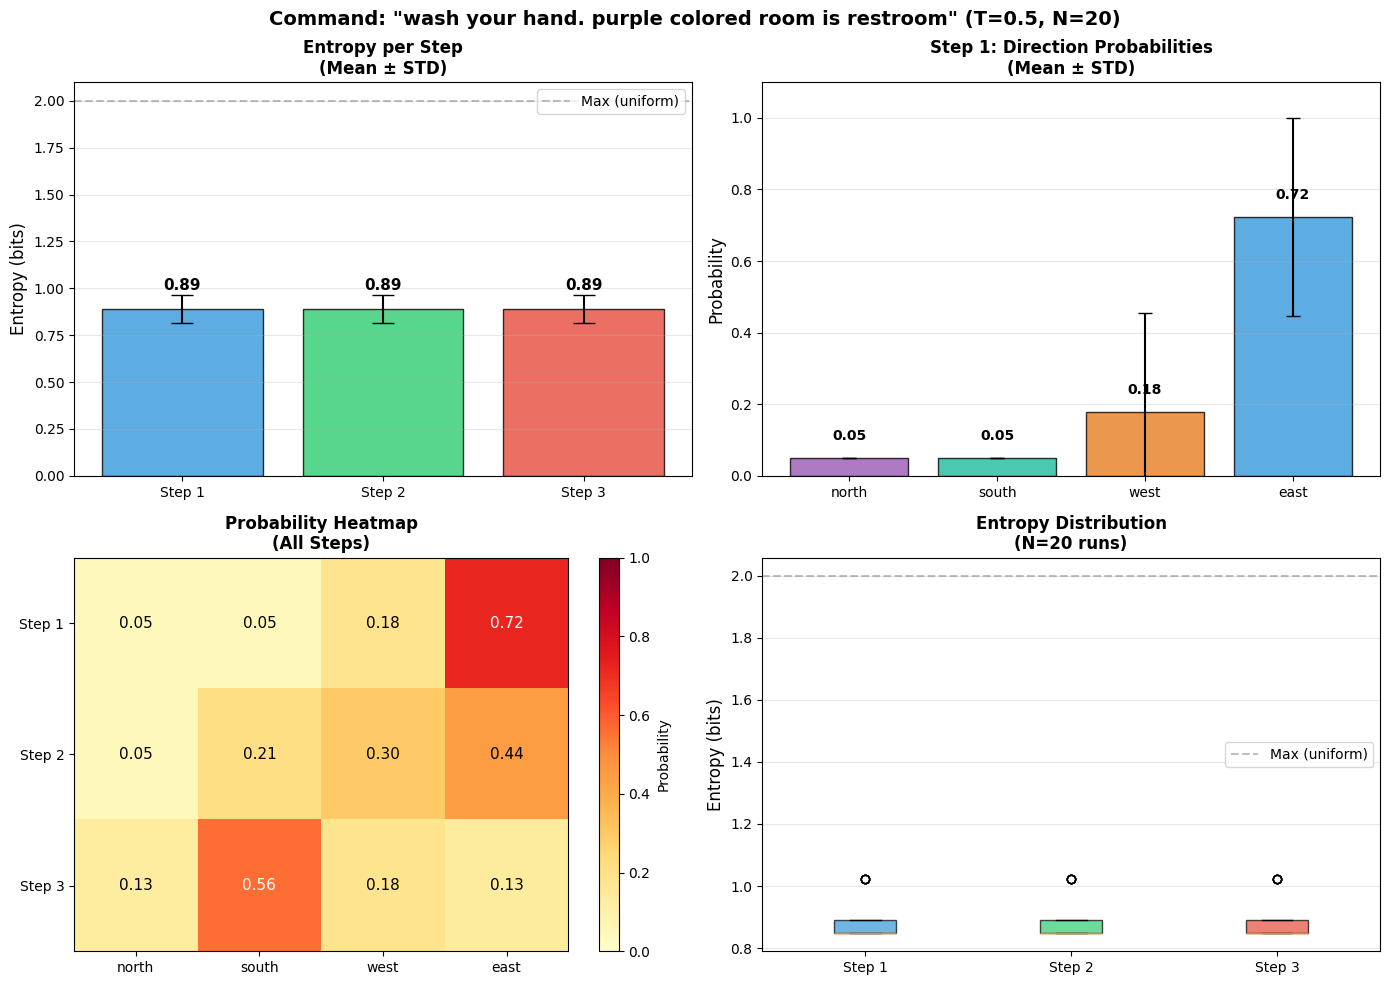

In [94]:
# ============================================
# Step-wise Calibration 테스트
# ============================================

# 예제 1: 명확한 방향 지정 → Step 1에서 east가 높은 확률 기대
stepwise_stats = run_stepwise_repeated(
    user_command="wash your hand. purple colored room is restroom",
    n_runs=20,
    temperature=0.5
)

# 예제 2: 모호한 명령 → 확률이 고르게 분포 기대
# stepwise_stats = run_stepwise_repeated(
#     user_command="explore the area",
#     n_runs=5,
#     temperature=0.3
# )

# 예제 3: 목표 기반 명령
# stepwise_stats = run_stepwise_repeated(
#     user_command="move toward red apple",
#     n_runs=5,
#     temperature=0.3
# )